In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
gc.collect()
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries
# preprocessing
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
#Reduce the memory usage - by Panchajanya Banerjee
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [116]:
train = reduce_mem_usage(pd.read_csv('train.csv',parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('test.csv', parse_dates=["first_active_month"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [117]:
test.first_active_month = test.first_active_month.fillna(pd.to_datetime('2017-09-01'))
test.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [7]:
# Taking Reference from Other Kernels
def aggregate_transaction_hist(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max', 'var'],
        'month_diff_lag' : ['mean', 'min', 'max', 'var'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [8]:
transactions = reduce_mem_usage(pd.read_csv('historical_transactions_clean_outlier.csv'))
transactions = transactions.loc[transactions.purchase_amount < 100,]
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 1638.06 Mb (50.8% reduction)


In [9]:
#Feature Engineering - Adding new features 
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['quarter'] = transactions['purchase_date'].dt.quarter
transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - transactions['purchase_date']).dt.days)//30
transactions['month_diff_lag'] = transactions['month_diff'] + transactions['month_lag']

gc.collect()

140

In [10]:
def aggregate_bymonth(trans, prefix):  
        
    agg_func = {
        'purchase_amount': ['sum', 'mean'],
        'card_id' : ['size'],
        'merchant_category_id' : ['nunique', lambda x:stats.mode(x)[0]],
#         'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
#         'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id','month','year']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

merge = aggregate_bymonth(transactions, prefix='hist_')
merge = merge.drop(['hist_transactions_count'], axis = 1)
merge['Date'] = pd.to_datetime(merge[['year', 'month']].assign(Day=1))

In [118]:
# adf = merge.groupby(['card_id', 'hist_merchant_category_id_<lambda>']).size().reset_index(name='Count')
# adf = adf.loc[adf.Count > 1]
# adf = adf.groupby(['card_id']).agg({'Count':['sum']})
# adf.columns = ['category_repeated_month']

train = pd.merge(train, adf, on='card_id',how='left')
test = pd.merge(test, adf, on='card_id',how='left')
gc.collect()

53874

In [119]:
# last month and first month
# merge1 = merge.loc[merge.groupby('card_id').Date.idxmax(),:][[ 'card_id','hist_card_id_size',
#                                                           'hist_purchase_amount_sum','hist_purchase_amount_mean']]
# new_names = [(i,i+'_last') for i in merge1.iloc[:, 1:].columns.values]
# merge1.rename(columns = dict(new_names), inplace=True)

# merge2 = merge.loc[merge.groupby('card_id').Date.idxmin(),:][['card_id','hist_card_id_size',
#                                                           'hist_purchase_amount_sum','hist_purchase_amount_mean']]
# new_names = [(i,i+'_first') for i in merge2.iloc[:, 1:].columns.values]
# merge2.rename(columns = dict(new_names), inplace=True)
# comb = pd.merge(merge1, merge2, on='card_id',how='left')

train = pd.merge(train, comb, on='card_id',how='left')
test = pd.merge(test, comb, on='card_id',how='left')

In [120]:
# Same merchant purchase
# df0 = (transactions.groupby(['card_id','merchant_id','purchase_amount']).size().reset_index(name='count_hist'))
# df0['purchase_amount_hist'] = df0['purchase_amount']
# df0['count_hist'] = df0.groupby(['card_id','merchant_id'])['count_hist'].transform('sum')
# df0 = df0.drop_duplicates()
# df0 = df0.loc[df0['count_hist'] >= 2]
# agg_func = {
#     'count_hist' : ['count'],
#     'purchase_amount_hist':['sum','mean'],
# }
# df0 = df0.groupby(['card_id']).agg(agg_func)
# df0.columns = [''.join(col).strip() for col in df0.columns.values]

train = pd.merge(train, df0, on='card_id',how='left')
test = pd.merge(test, df0, on='card_id',how='left')

In [121]:
#Same category purchase
# df1 = (transactions.groupby(['card_id','merchant_category_id','purchase_amount']).size().reset_index(name='hist_count'))
# df1['hist_purchase_amount'] = df1.groupby(['card_id','merchant_category_id'])['purchase_amount'].transform('sum')
# df1['hist_count'] = df1.groupby(['card_id','merchant_category_id'])['hist_count'].transform('sum')
# df1 = df1.drop_duplicates()
# df1 = df1.loc[df1['hist_count'] >= 2]
# df1['hist_count_4'] = 0
# df1.loc[df1['hist_count'] >= 4, 'hist_count_4'] = 1
# df1['hist_mean4'] = 0
# df1.loc[df1['hist_count'] >= 4, 'hist_mean4'] = df1['hist_purchase_amount']/df1['hist_count']
# df1['hist_purchase_amount'] = df1['purchase_amount']
# agg_fun = {
#     'hist_count' : ['count'],
#     'hist_count_4' : ['sum'],
#     'hist_purchase_amount':['sum','mean'],
#     'hist_mean4' : ['sum','mean']
# }
# df1 = df1.groupby(['card_id']).agg(agg_fun)
# df1.columns = [''.join(col).strip() for col in df1.columns.values]

train = pd.merge(train, df1, on='card_id',how='left')
test = pd.merge(test, df1, on='card_id',how='left')

In [16]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id'
                           ], axis = 1)
d = dict(zip(merchants.columns[1:], ['histchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "hist_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.histchant_active_months_lag12 = pd.cut(merchants.histchant_active_months_lag12, 4)

Mem. usage decreased to 16.91 Mb (71.2% reduction)


In [17]:
merge_trans = aggregate_transaction_hist(transactions, prefix='hist_')
merge_trans = merge_trans.merge(merchants, on = 'hist_merchant_id_<lambda>', how = 'left')
## hist transaction frequency
merge_trans['hist_freq'] = merge_trans.hist_transactions_count/(((merge_trans.hist_purchase_date_max - 
                                                         merge_trans.hist_purchase_date_min).dt.total_seconds())/86400)
merge_trans['hist_freq_amount'] = merge_trans['hist_freq'] * merge_trans['hist_purchase_amount_mean']

In [19]:
cols = ['histchant_avg_sales_lag3','histchant_avg_purchases_lag3',
        'histchant_avg_sales_lag6','histchant_avg_purchases_lag6',
        'histchant_avg_sales_lag12','histchant_avg_purchases_lag12','hist_freq']
for col in cols:
    merge_trans[col] = pd.qcut(merge_trans[col], 4)

In [20]:
for col in cols:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_trans[col].values)) 
    merge_trans[col] = label_enc.transform(list(merge_trans[col].values))

In [21]:
for col in ['histchant_category_1','histchant_most_recent_sales_range','histchant_most_recent_purchases_range',
           'histchant_active_months_lag12','histchant_category_4','histchant_category_2']:
    merge_trans[col].fillna(merge_trans[col].mode()[0], inplace=True)

In [22]:
label_enc.fit(list(merge_trans['hist_merchant_id_<lambda>'].values)) 
merge_trans['hist_merchant_id_<lambda>'] = label_enc.transform(list(merge_trans['hist_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_trans['histchant_active_months_lag12'].values)) 
merge_trans['histchant_active_months_lag12'] = label_enc.transform(list(merge_trans['histchant_active_months_lag12'].values))

In [122]:
#del transactions
gc.collect()
train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
#del merge_trans
gc.collect()

28

In [123]:
#Feature Engineering - Adding new features 
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_max']).dt.days
train['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['hist_purchase_date_min']).dt.days
train['hist_first_buy'] = (train['hist_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9
gc.collect()

48

In [124]:
#Feature Engineering - Adding new features 
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_max']).dt.days
test['hist_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['hist_purchase_date_min']).dt.days
test['hist_first_buy'] = (test['hist_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['hist_purchase_date_max','hist_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9

gc.collect()

75

In [26]:
# Taking Reference from Other Kernels
def aggregate_transaction_new(trans, prefix):  
        
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean', 'min', 'max'],
        'month_diff_lag' : ['mean', 'min', 'max'],
        'weekend' : ['sum', 'mean'],
        'category_1': ['sum','mean', 'max','min'],
        'purchase_amount': ['sum', 'mean', 'max', 'min'],
        'installments': ['sum', 'mean', 'max', 'min'],  
        'month_lag': ['max','min','mean'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique'],
        'merchant_id' : ['nunique', lambda x:stats.mode(x)[0]],
        'state_id' : ['nunique', lambda x:stats.mode(x)[0]],
    }
    
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [27]:
# Now extract the data from the new transactions
new_transactions = reduce_mem_usage(pd.read_csv('new_merchant_transactions_clean_outlier.csv'))
new_transactions = new_transactions.loc[new_transactions.purchase_amount < 100,]
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 0, 'N': 1})

Mem. usage decreased to 106.71 Mb (52.5% reduction)


In [28]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['quarter'] = new_transactions['purchase_date'].dt.quarter
new_transactions['is_month_start'] = new_transactions['purchase_date'].dt.is_month_start
new_transactions['month_diff'] = ((pd.to_datetime('01/03/2018') - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff_lag'] = new_transactions['month_diff'] + new_transactions['month_lag']

gc.collect()

# new_transactions['Christmas_Day_2017'] = (pd.to_datetime('2017-12-25') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 15 else 0)
# new_transactions['Valentine_Day_2017'] = (pd.to_datetime('2017-06-13') - 
#                                           new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)
# #Black Friday : 24th November 2017
# new_transactions['Black_Friday_2017'] = (pd.to_datetime('2017-11-27') - 
#                                          new_transactions['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x <= 7 else 0)


169

In [125]:
## Same merchant purchase
df = (new_transactions.groupby(['card_id','merchant_id','purchase_amount']).size().reset_index(name='count_new'))
df['purchase_amount_new'] = df['purchase_amount']
df['count_new'] = df.groupby(['card_id','merchant_id'])['count_new'].transform('sum')
df = df.drop_duplicates()
df = df.loc[df['count_new'] >= 2]
agg_func = {
    'count_new' : ['count'],
    'purchase_amount_new':['sum','mean'],
}
df = df.groupby(['card_id']).agg(agg_func)
df.columns = [''.join(col).strip() for col in df.columns.values]

train = pd.merge(train, df, on='card_id',how='left')
test = pd.merge(test, df, on='card_id',how='left')

gc.collect()

77

In [126]:
## Same cate purchase
df = (new_transactions.groupby(['card_id','merchant_category_id','purchase_amount']).size().reset_index(name='new_count'))
df['new_count'] = df.groupby(['card_id','merchant_category_id'])['new_count'].transform('sum')
df = df.drop_duplicates()
df = df.loc[df['new_count'] >= 2]
df['new_count_4'] = 0
df.loc[df['new_count'] >= 4, 'new_count_4'] = 1
df['new_samecate_purchase'] = df['purchase_amount']
agg_fun = {
    'new_count' : ['count'],
    'new_count_4' : ['sum'],
    'new_samecate_purchase':['sum','mean']
}
df = df.groupby(['card_id']).agg(agg_fun)
df.columns = [''.join(col).strip() for col in df.columns.values]

train = pd.merge(train, df, on='card_id',how='left')
test = pd.merge(test, df, on='card_id',how='left')

gc.collect()

35

In [31]:
merchants = reduce_mem_usage(pd.read_csv('merchants_clean.csv'))
merchants = merchants.drop(['Unnamed: 0', 'merchant_group_id', 'merchant_category_id',
                            'subsector_id', 'numerical_1', 'numerical_2', 
                            'active_months_lag3','active_months_lag6',
                            'city_id', 'state_id',
                           ], axis = 1)
d = dict(zip(merchants.columns[1:], ['newchant_{}'.format(x) for x in (merchants.columns[1:])]))
d.update({"merchant_id": "new_merchant_id_<lambda>"})
merchants = merchants.rename(index=str, columns= d)
## convert the month in business to categorical
merchants.newchant_active_months_lag12 = pd.cut(merchants.newchant_active_months_lag12, 4)

Mem. usage decreased to 16.91 Mb (71.2% reduction)


In [32]:
merge_new = aggregate_transaction_new(new_transactions, prefix='new_')
merge_new = merge_new.merge(merchants, on = 'new_merchant_id_<lambda>', how = 'left')
## new transaction frequency
merge_new['new_freq'] = merge_new.new_transactions_count/(((merge_new.new_purchase_date_max - 
                                                         merge_new.new_purchase_date_min).dt.total_seconds())/86400)
merge_new['new_freq_amount'] = merge_new['new_freq'] * merge_new['new_purchase_amount_mean']
merge_new['new_freq_install'] = merge_new['new_freq'] * merge_new['new_installments_mean']

In [33]:
cols = ['newchant_avg_sales_lag3','newchant_avg_purchases_lag3',
        'newchant_avg_sales_lag6','newchant_avg_purchases_lag6',
        'newchant_avg_sales_lag12','newchant_avg_purchases_lag12','new_freq']
for col in cols:
    merge_new[col] = pd.qcut(merge_new[col], 4)

In [34]:
for col in cols:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)
    label_enc.fit(list(merge_new[col].values)) 
    merge_new[col] = label_enc.transform(list(merge_new[col].values))

In [35]:
for col in ['newchant_category_1','newchant_most_recent_sales_range','newchant_most_recent_purchases_range',
           'newchant_active_months_lag12','newchant_category_4','newchant_category_2']:
    merge_new[col].fillna(merge_new[col].mode()[0], inplace=True)

In [36]:
label_enc.fit(list(merge_new['new_merchant_id_<lambda>'].values)) 
merge_new['new_merchant_id_<lambda>'] = label_enc.transform(list(merge_new['new_merchant_id_<lambda>'].values))
label_enc.fit(list(merge_new['newchant_active_months_lag12'].values)) 
merge_new['newchant_active_months_lag12'] = label_enc.transform(list(merge_new['newchant_active_months_lag12'].values))

In [127]:
#del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
#del merge_new

gc.collect()

14

In [137]:
train_na = train.isnull().sum()
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Value' :train_na})
missing_data.head(5)

,Missing Value


In [128]:
for col in ['new_freq','new_purchase_amount_min','new_purchase_amount_max','newchant_category_4','new_weekend_mean',
            'new_purchase_amount_mean','newchant_active_months_lag12','new_weekend_sum','newchant_avg_purchases_lag12',
            'newchant_avg_sales_lag12','newchant_avg_purchases_lag6','newchant_avg_sales_lag6','new_category_1_sum',
            'newchant_avg_purchases_lag3','newchant_avg_sales_lag3','new_category_1_mean','new_category_1_max',
            'new_category_1_min','newchant_most_recent_purchases_range','newchant_most_recent_sales_range',
            'newchant_category_1'] :     # -1
    train[col] = train[col].fillna(-1.0)
    test[col] = test[col].fillna(-1.0)
    
for col in ['new_installments_min','new_installments_max','new_installments_mean','new_installments_sum',
            'new_purchase_amount_sum','new_state_id_<lambda>' ]:      # -2
    train[col] = train[col].fillna(-2.0)
    test[col] = test[col].fillna(-2.0)
    
for col in ['newchant_category_2','new_month_lag_min','new_month_lag_max','new_month_lag_mean','new_weekofyear_nunique',
            'new_year_nunique','new_state_id_nunique','new_merchant_id_<lambda>','new_merchant_id_nunique',
            'new_merchant_category_id_nunique','new_subsector_id_nunique','new_dayofweek_nunique','new_hour_nunique',
            'new_month_nunique','new_transactions_count','new_count_4sum','new_countcount','hist_count_4sum',
            'hist_countcount','hist_purchase_amountmean','hist_purchase_amountsum','purchase_amount_newmean',
            'purchase_amount_newsum','count_newcount','purchase_amount_histmean','purchase_amount_histsum',
            'count_histcount','hist_mean4mean','hist_mean4sum','new_samecate_purchasemean','new_samecate_purchasesum',
            'category_repeated_month']:      # 0
    train[col] = train[col].fillna(0.0)
    test[col] = test[col].fillna(0.0)
    
train.new_month_diff_mean = train.new_month_diff_mean.fillna(23)
train.new_month_diff_min = train.new_month_diff_min.fillna(23)
train.new_month_diff_max = train.new_month_diff_max.fillna(24)
train.new_month_diff_lag_mean = train.new_month_diff_lag_mean.fillna(24)
train.new_month_diff_lag_min = train.new_month_diff_lag_min.fillna(24)
train.new_month_diff_lag_max = train.new_month_diff_lag_max.fillna(24)

test.new_month_diff_mean = test.new_month_diff_mean.fillna(23)
test.new_month_diff_min = test.new_month_diff_min.fillna(23)
test.new_month_diff_max = test.new_month_diff_max.fillna(24)
test.new_month_diff_lag_mean = test.new_month_diff_lag_mean.fillna(24)
test.new_month_diff_lag_min = test.new_month_diff_lag_min.fillna(24)
test.new_month_diff_lag_max = test.new_month_diff_lag_max.fillna(24)

In [129]:
for col in ['new_purchase_date_min','new_purchase_date_max']:
    train[col] = train[col].fillna(pd.to_datetime(1/9/2017))
    test[col] = test[col].fillna(pd.to_datetime(1/9/2017))

In [130]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['total_count_merid'] = train['count_newcount'] + train['count_histcount']
train['total_count'] = train['new_countcount'] + train['hist_countcount']
train['new_purchase_date_max'] = pd.to_datetime(train['new_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['new_purchase_date_min'])
train['new_purchase_date_diff'] = (train['new_purchase_date_max'] - train['new_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['new_purchase_date_diff']/train['new_card_id_size']
train['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_max']).dt.days
train['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - train['new_purchase_date_min']).dt.days
train['new_first_buy'] = (train['new_purchase_date_min'] - train['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    train[feature] = train[feature].astype(np.int64) * 1e-9

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['total_count_merid'] = test['count_newcount'] + test['count_histcount']
test['total_count'] = test['new_countcount'] + test['hist_countcount']
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_max']).dt.days
test['new_purchase_date_uptomin'] = (pd.to_datetime('01/03/2018') - test['new_purchase_date_min']).dt.days
test['new_first_buy'] = (test['new_purchase_date_min'] - test['first_active_month']).dt.days
for feature in ['new_purchase_date_max','new_purchase_date_min']:
    test[feature] = test[feature].astype(np.int64) * 1e-9
    
#added new feature - Interactive
train['card_id_total'] = train['new_transactions_count'] + train['hist_transactions_count']
train['purchase_amount_total'] = train['new_purchase_amount_sum'] + train['hist_purchase_amount_sum']

test['card_id_total'] = test['new_transactions_count'] + test['hist_transactions_count']
test['purchase_amount_total'] = test['new_purchase_amount_sum'] + test['hist_purchase_amount_sum']

gc.collect()

206

In [131]:
# last month over hist
train['amountmean_ratiolast'] = train.hist_purchase_amount_mean_last/train.hist_purchase_amount_mean
train['amountsum_ratiolast'] = train.hist_purchase_amount_sum_last/train.hist_purchase_amount_sum
train['transcount_ratiolast'] = train.hist_card_id_size_last/(train.hist_transactions_count/(train.hist_purchase_date_diff//30))

test['amountmean_ratiolast'] = test.hist_purchase_amount_mean_last/test.hist_purchase_amount_mean
test['amountsum_ratiolast'] = test.hist_purchase_amount_sum_last/test.hist_purchase_amount_sum
test['transcount_ratiolast'] = test.hist_card_id_size_last/(test.hist_transactions_count/(test.hist_purchase_date_diff//30))

In [113]:
# train['amountmean_ratiofirst'] = train.hist_purchase_amount_mean_first/train.hist_purchase_amount_mean
# train['amountsum_ratiofirst'] = train.hist_purchase_amount_sum_first/train.hist_purchase_amount_sum
# train['transcount_ratiofirst'] = train.hist_card_id_size_first/(train.hist_transactions_count/(train.hist_purchase_date_diff//30))

# test['amountmean_ratiofirst'] = test.hist_purchase_amount_mean_first/test.hist_purchase_amount_mean
# test['amountsum_ratiofirst'] = test.hist_purchase_amount_sum_first/test.hist_purchase_amount_sum
# test['transcount_ratiofirst'] = test.hist_card_id_size_first/(test.hist_transactions_count/(test.hist_purchase_date_diff//30))

In [114]:
# train['amountmean_lastfirst'] = train.hist_purchase_amount_mean_last/train.hist_purchase_amount_mean_first
# train['amountsum_lastfirst'] = train.hist_purchase_amount_sum_last/train.hist_purchase_amount_sum_first
# train['transcount_lastfirst'] = train.hist_card_id_size_last/train.hist_card_id_size_first

# test['amountmean_lastfirst'] = test.hist_purchase_amount_mean_last/test.hist_purchase_amount_mean_first
# test['amountsum_lastfirst'] = test.hist_purchase_amount_sum_last/test.hist_purchase_amount_sum_first
# test['transcount_lastfirst'] =  test.hist_card_id_size_last/test.hist_card_id_size_first
# train = train.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month'], axis = 1)
# test = test.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month'], axis = 1)

In [133]:
train.new_purchase_date_average = train.new_purchase_date_average.fillna(-1.0)
test.new_purchase_date_average = test.new_purchase_date_average.fillna(-1.0)

In [134]:
cols = ['new_freq_amount',]
for col in cols:
    train[col] = train[col].fillna(0)
    train[col] = pd.qcut(train[col], 5)
    label_enc.fit(list(train[col].values)) 
    train[col] = label_enc.transform(list(train[col].values))
    
    test[col] = test[col].fillna(0)
    test[col] = pd.qcut(test[col], 5)
    label_enc.fit(list(test[col].values)) 
    test[col] = label_enc.transform(list(test[col].values))

train = train.drop(['new_freq_install'], axis = 1) 
test = test.drop(['new_freq_install'], axis = 1)  

In [135]:
train = train.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month'], axis = 1)
test = test.drop(['hist_card_id_size','new_card_id_size','card_id', 'first_active_month'], axis = 1)

In [136]:
train.shape

(201917, 153)

In [138]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [139]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['target','outliers']] 
cat_features = [c for c in df_train_columns if 'feature_' in c] 
#df_train_columns

In [140]:
target = train['target']
del train['target']

In [141]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=6, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1457]	training's rmse: 3.27971	valid_1's rmse: 3.6458
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1439]	training's rmse: 3.28377	valid_1's rmse: 3.63848
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1679]	training's rmse: 3.25245	valid_1's rmse: 3.65313
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1358]	training's rmse: 3.29276	valid_1's rmse: 3.65687
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1626]	training's rmse: 3.24468	valid_1's rmse: 3.6667
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1186]	training's rmse: 3.31775	valid_1's rmse: 3.64535


3.6510676576993872

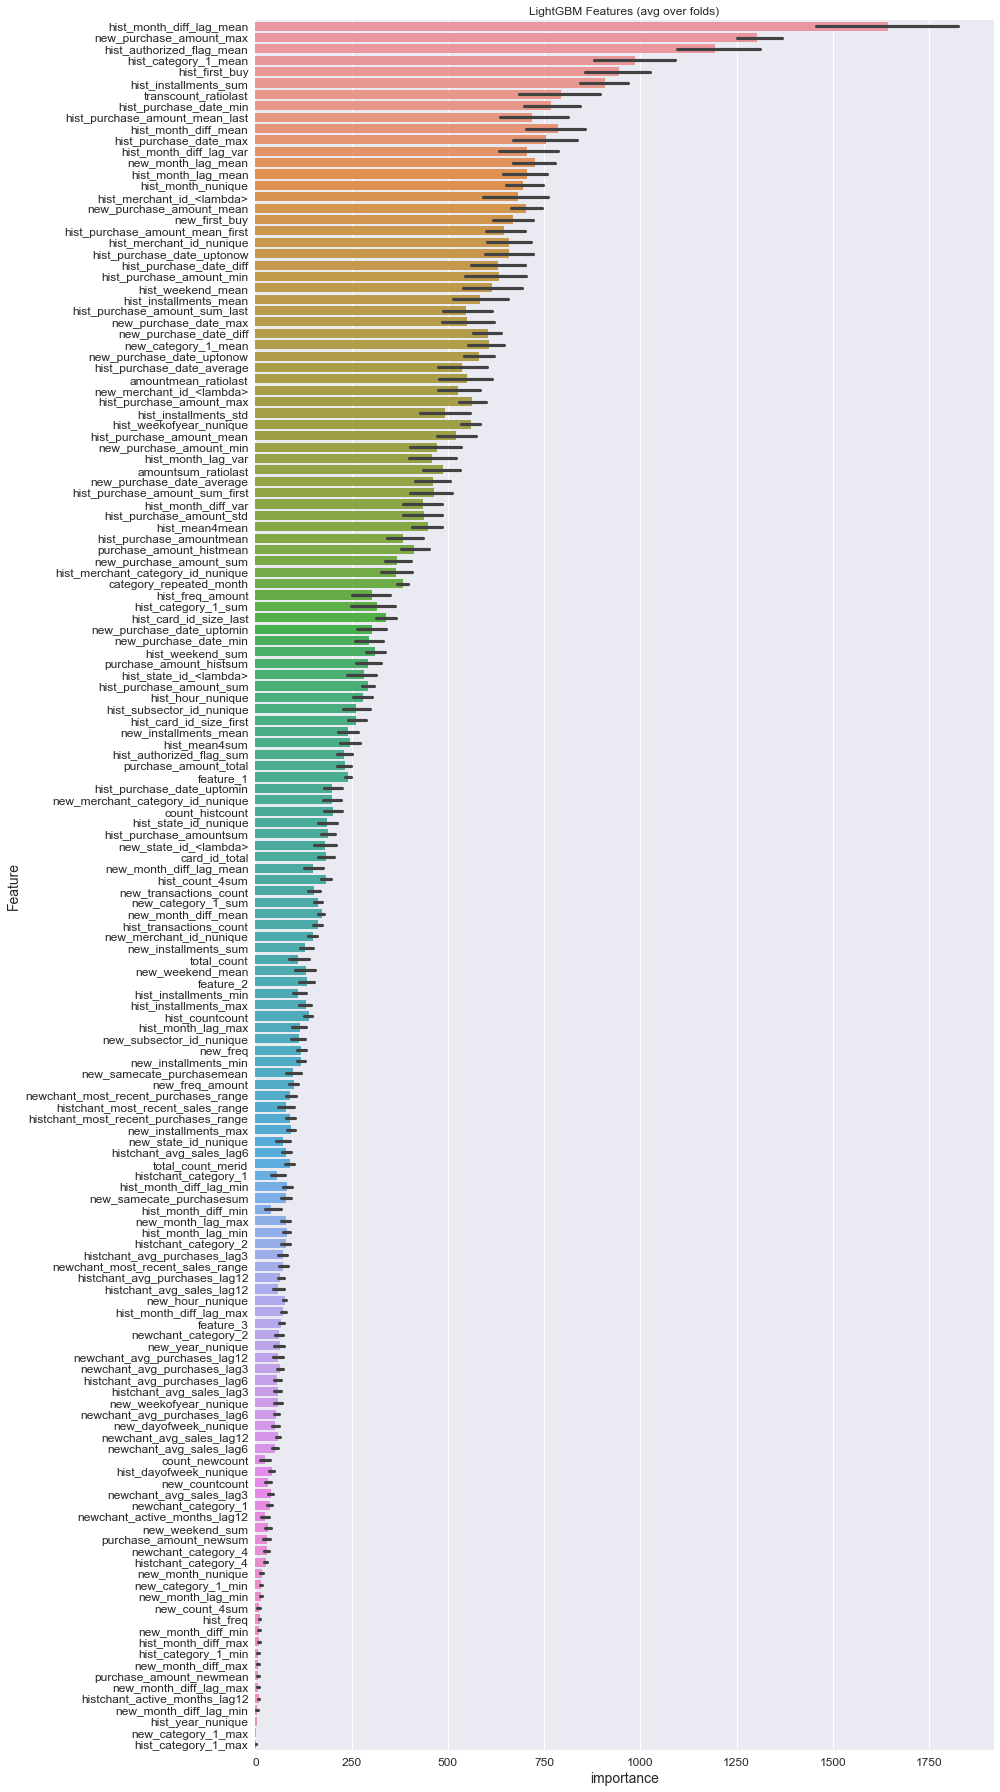

In [142]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [143]:
features = [c for c in train.columns if c not in ['target','outliers']]
cat_features = [c for c in features if 'feature_' in c]

In [144]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = RepeatedKFold(n_splits=6, n_repeats=2, random_state=4590)
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=cat_features)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=cat_features)

    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1537]	training's rmse: 3.24408	valid_1's rmse: 3.76088
fold 1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1609]	training's rmse: 3.25401	valid_1's rmse: 3.65449
fold 2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1591]	training's rmse: 3.27355	valid_1's rmse: 3.56522
fold 3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1213]	training's rmse: 3.31182	valid_1's rmse: 3.66261
fold 4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1677]	training's rmse: 3.24792	valid_1's rmse: 3.63977
fold 5
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1482]	training's rmse: 3.27994	valid_1's rmse: 3.64087
fold 6
Training until validation s

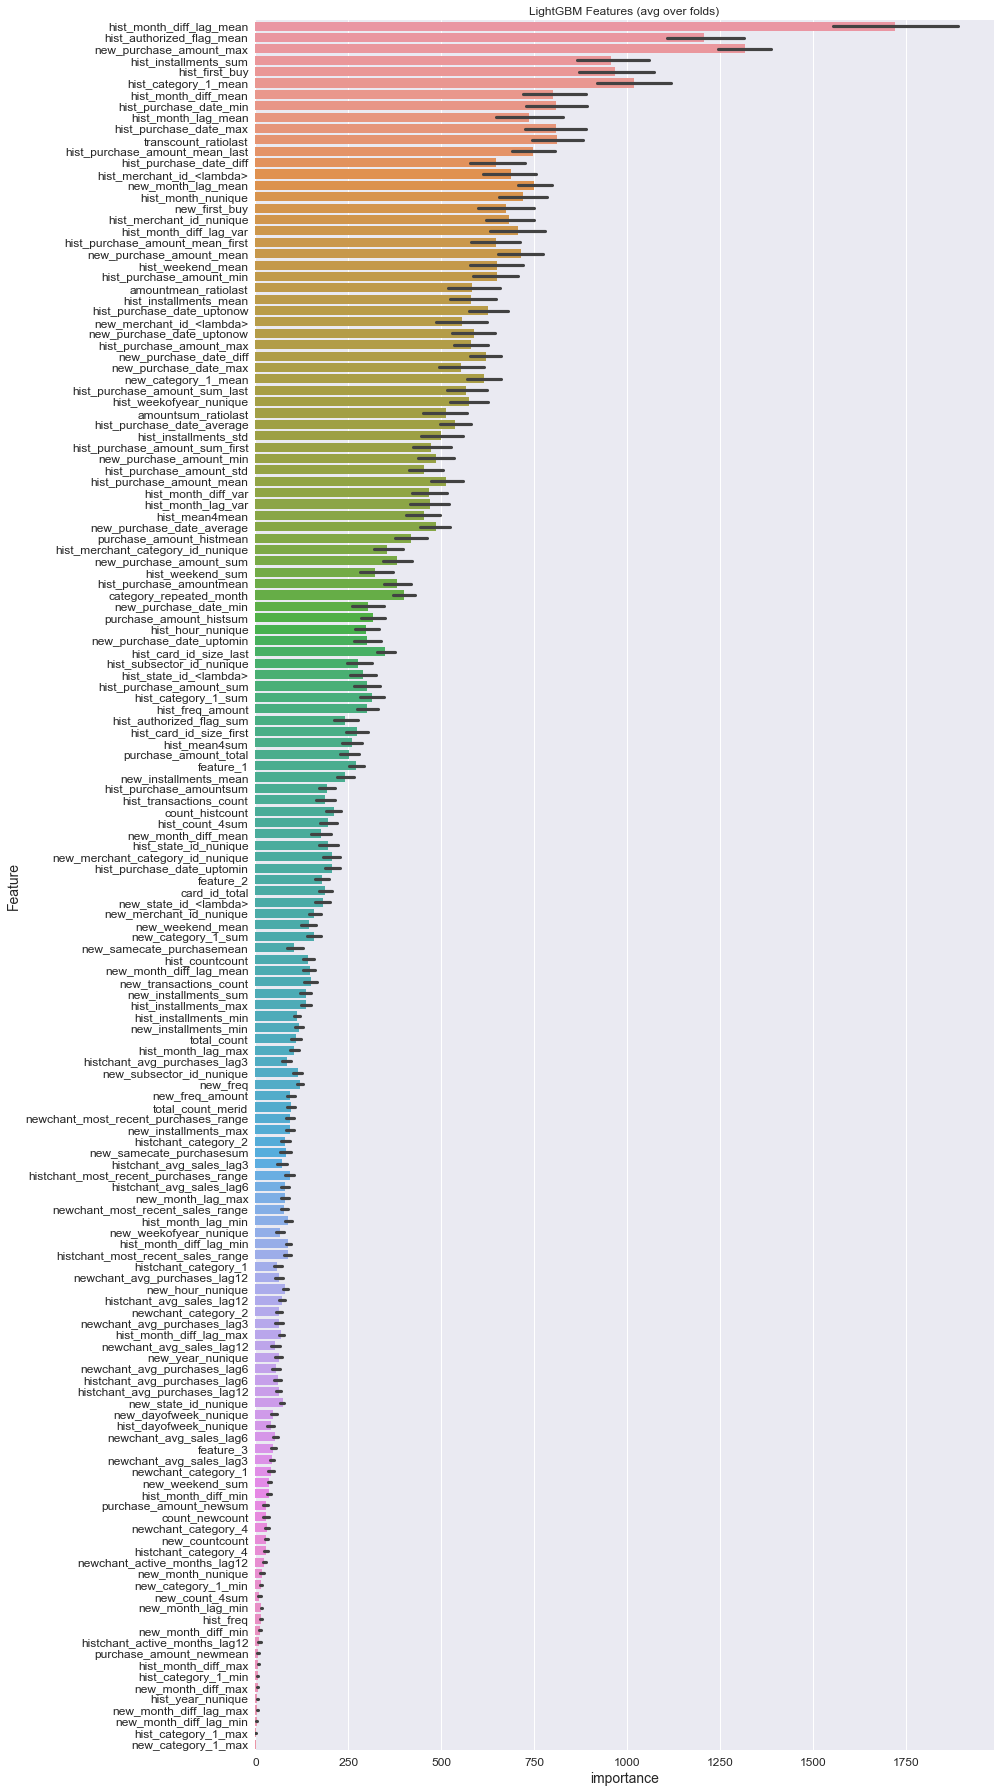

In [145]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [146]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2*10/12]).transpose()

folds_stack = RepeatedKFold(n_splits=6, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 6
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5


3.647537087358736

In [147]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = predictions_3
# combine = pd.read_csv('combining_submission.csv')
# sample_submission['target'] = predictions_3*0.7 + combine['target']*0.3
q = sample_submission['target'].quantile(0.002)
#sample_submission['target'] = sample_submission['target'].apply(lambda x: x if x > q else x*1.1)
# sample_submission.loc[sample_submission.target < -18, 'target'] = -33.218750
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
((sample_submission.target <= -30) & (sample_submission.target > -35)).sum()

In [ ]:
((target > -35) & (target < -30)).sum()

In [148]:
q

-10.603517281789921

In [150]:
sample_submission.loc[sample_submission.target < -18]

,card_id,target
5008,C_ID_be92f84f5c,-19.647435
17720,C_ID_938dec7a1a,-19.224912
20556,C_ID_aae50409e7,-22.493872
25568,C_ID_767923bdb9,-19.006703
26864,C_ID_e7c702e96f,-19.606682
27436,C_ID_493de71141,-18.580603
32446,C_ID_ac114ef831,-21.715071
35851,C_ID_5ee52cf9f6,-19.430751
37421,C_ID_366bf4ea4d,-19.529258
48945,C_ID_afbfc01b49,-20.630373


In [62]:
sample_submission.head(5)

,card_id,target
0,C_ID_0ab67a22ab,-2.964640
1,C_ID_130fd0cbdd,-0.176325
2,C_ID_b709037bc5,-0.875931
3,C_ID_d27d835a9f,-0.063151
4,C_ID_2b5e3df5c2,-1.321138


In [134]:
my = pd.read_csv('submission (1).csv')
my['target'][91179] = -33.218750
my.to_csv('submission91179.csv', index=False)

## Classification

In [136]:
import itertools
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn  import XGBClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions

In [137]:
y_train = train['outliers']
del train['outliers']

In [ ]:
train = train.drop(['target'],axis = 1)
test = test.drop(['target'],axis = 1)

In [138]:
train['target'] = target
test['target'] = predictions_3

In [139]:
clf1 = ExtraTreesClassifier(n_estimators= 500,
                             max_features= 'auto',
                             criterion= 'entropy',
                             min_samples_split= 2,
                             max_depth= 14,
                             min_samples_leaf= 1, 
                             class_weight='balanced_subsample',
                             random_state=132,
                             verbose=0,
                             n_jobs = -1)

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf1.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf1.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred1 = clf1.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.9994453177681859


In [158]:
clf2 = RandomForestClassifier(
    n_estimators=500,
    criterion='gini',
    max_depth= 7,
    min_samples_split=2,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features=14,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=123,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
outcomes = []
    
for (x, y), i in zip(cv.split(train, y_train), range(5)):
    Xtrain, Xtest = train.values[x], train.values[y]
    ytrain, ytest = y_train.values[x], y_train.values[y]
    clf2.fit(train.iloc[x], y_train.iloc[x]) 
    predictions = clf2.predict(Xtest)
    accuracy = accuracy_score(ytest, predictions)
    outcomes.append(accuracy)

pred2 = clf2.predict(test)
mean_outcome = np.mean(outcomes)
print("Mean Accuracy: {0}".format(mean_outcome)) 

Mean Accuracy: 0.9917936665206402


In [146]:
pred = clf1.fit(train, y_train).predict(test)

In [159]:
sample_submission['outliers'] = pred2
sample_submission.loc[(sample_submission['outliers'] == 1)]

,card_id,target,outliers
156,C_ID_87c16e5496,-3.324023,1
162,C_ID_10a8a42d77,-9.497928,1
170,C_ID_5ac4488f3c,-3.723090,1
232,C_ID_5089081961,-5.646757,1
496,C_ID_a7d1cd6b7c,-16.537120,1
514,C_ID_45a7272424,-7.512258,1
694,C_ID_a45d84ca4c,-6.603710,1
984,C_ID_0defbecf99,-2.820519,1
1449,C_ID_5901d1f7b4,-8.385064,1
1732,C_ID_0d3a4db1a6,-9.140478,1
